# TP Recommendation
Loïc Herbelot

### Question 1.1 : Chargement des données

In [105]:
import numpy as np
from scipy import sparse


def load_movielens(filename, minidata=False):
    """
    Cette fonction lit le fichier filename de la base de donnees
    Movielens, par exemple 
    filename = '~/datasets/ml-100k/u.data'
    Elle retourne 
    R : une matrice utilisateur-item contenant les scores
    mask : une matrice valant 1 si il y a un score et 0 sinon
    """

    data = np.loadtxt(filename, dtype=int)

    R = sparse.coo_matrix((data[:, 2], (data[:, 0]-1, data[:, 1]-1)),
                          dtype=float)
    R = R.toarray()  # not optimized for big data

    # code la fonction 1_K
    mask = sparse.coo_matrix((np.ones(data[:, 2].shape),
                              (data[:, 0]-1, data[:, 1]-1)), dtype=bool )
    mask = mask.toarray()  # not optimized for big data

    if minidata is True:
        R = R[0:100, 0:200].copy()
        mask = mask[0:100, 0:200].copy()

    return R, mask


def objective(P, Q0, R, mask, rho):
    """
    La fonction objectif du probleme simplifie.
    Prend en entree 
    P : la variable matricielle de taille C x I
    Q0 : une matrice de taille U x C
    R : une matrice de taille U x I
    mask : une matrice 0-1 de taille U x I
    rho : un reel positif ou nul

    Sorties :
    val : la valeur de la fonction
    grad_P : le gradient par rapport a P
    """

    tmp = (R - Q0.dot(P)) * mask

    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q0 ** 2) + np.sum(P ** 2))

    grad_P = -Q0.T.dot(tmp) + rho*P

    return val, grad_P


def total_objective(P, Q, R, mask, rho):
    """
    La fonction objectif du probleme complet.
    Prend en entree 
    P : la variable matricielle de taille C x I
    Q : la variable matricielle de taille U x C
    R : une matrice de taille U x I
    mask : une matrice 0-1 de taille U x I
    rho : un reel positif ou nul

    Sorties :
    val : la valeur de la fonction
    grad_P : le gradient par rapport a P
    grad_Q : le gradient par rapport a Q
    """

    tmp = (R - Q.dot(P)) * mask

    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q ** 2) + np.sum(P ** 2))

    grad_P = 0  # todo

    grad_Q = 0  # todo

    return val, grad_P, grad_Q


def total_objective_vectorized(PQvec, R, mask, rho):
    """
    Vectorisation de la fonction precedente de maniere a ne pas
    recoder la fonction gradient
    """

    # reconstruction de P et Q
    n_items = R.shape[1]
    n_users = R.shape[0]
    F = PQvec.shape[0] / (n_items + n_users)
    Pvec = PQvec[0:n_items*F]
    Qvec = PQvec[n_items*F:]
    P = np.reshape(Pvec, (F, n_items))
    Q = np.reshape(Qvec, (n_users, F))

    val, grad_P, grad_Q = total_objective(P, Q, R, mask, rho)
    return val, np.concatenate([grad_P.ravel(), grad_Q.ravel()])


In [106]:
import numpy as np

filename = "ml-100k/u.data"

#sans "minidata"
R, mask = load_movielens(filename)
print("Taille de R:", R.shape)
print("Taille de mask:", mask.shape)

Taille de R: (943, 1682)
Taille de mask: (943, 1682)


In [107]:
#avec "minidata"
R_mini, mask_mini = load_movielens(filename, minidata=True)
print("Taille de R_mini:", R_mini.shape)
print("Taille de mask_mini:", mask_mini.shape)

Taille de R_mini: (100, 200)
Taille de mask_mini: (100, 200)


### Fonction de `minidata` :
Comme on peut le voir dans le code source, l'argument `minidata` sert à indiquer si l'on veut une plus petite partie des informations, seulement 100 lignes et 200 colonnes.

### Question 1.2 : Informations sur les données

In [108]:
with open("ml-100k/u.info") as f:
    print("Contenu du fichier d'info : \n"+ f.read())

Contenu du fichier d'info : 
943 users
1682 items
100000 ratings



On voit qu'on a donc :
 * 943 utilisateurs
 * 1682 films
 * Pour un total de 100 000 notes.

### Question 1.3 : Étude de la fonction objectif

Ici j'ai tracé la fonction avec deux variables :
![Graphe de la fonction objectif avec deux variables](plot_objective_2_var.png)


On voit donc que la fonction n'est pas convexe.

Le gradient de f est :

$\nabla f(P,Q) = (Q^T (1_K ⋅ (QP-R)) + \rho P, 1_K ⋅ (QP-R)P^T + \rho Q)$

Le gradient de $f$ n'est pas lipschitzien, car ses dérivées partielles ne sont pas bornées.

Exemple en dimension 1 :
$f(x,y) = \frac 1 2 (r- xy)^2 + \frac \rho 2 (x^2 + y^2) $

$\frac{df}{dx}(x) = x(y^2 + \rho) - yr$ et n'est pas bornée

### Question 2.1 :

La fonction $g$ est convexe.

Son gradient vaut : $\nabla g(P) = -{Q^0}^T(1_K ⋅ (R - Q^0*P)) + \rho P $



### Question 2.2 : Calcul du gradient de $g$

In [109]:
from scipy.optimize import check_grad

# Initialisation des variables :
rho = 0.2
P = np.random.random((7, 1682))*100

# Fonctions utilisées pour la vérification du gradient :

# def g(P):
#     """ Renvoie la sortie de la fonction objectif.
#     :param P: un vecteur ligne de 7*1682 éléments
#     :return : la sortie de la fonction objectif."""
#     P = P.reshape((7, 1682))
#     return objective(P, Q0, R, mask, rho)[0]

# def grad_g(P):
#     """Renvoie le gradient de la fonction objectif au point P.
#     :param P: un vecteur ligne de 7*1682 éléments
#     :return: le gradient sous forme de vecteur ligne."""
#     P = P.reshape((7, 1682))
#     return objective(P, Q0, R, mask, rho)[1].ravel()

# Activer/Désactiver la vérification du gradient :
verif = False # Choix de l'utilisateur
if verif :
    # Attention, calcul très long :
    print("Erreur sur le gradient :")
    for i in range(1):
        Q0 = np.random.random((943, 7))
        P = np.random.random((7, 1682))
        print("Vérification n°%d :" % i)
        print(check_grad(lambda P:objective(P.reshape((7, 1682)), Q0, R, mask, rho)[0],
                         lambda P:objective(P.reshape((7, 1682)), Q0, R, mask, rho)[1].ravel(),
                         P.ravel()))
else :
    print("Vérification sautée.")


Vérification sautée.


### Question 2.3 : Gradient à pas constant

In [110]:
from scipy.sparse.linalg import svds

def gradient(objective, P0, gamma=1, epsilon=1, n_iter=1000, verbose=True):
    """ Minimise une fonction objectif par la méthode du gradient à pas constant.
    :param g:       La fonction à minimiser
    :param P0:      Le point de départ
    :param gamma:   Le pas
    :param epsilon: Critère d'arrêt : norme du gradient inférieure à epsilon
    :param n_iter:  Le nombre maximum d'itérations
    
    :return: Le point qui minimise la fonction, la valeur de la fonction en ce point, et son gradient
    """
    #Q0 est la matrice des 7 vecteurs singuliers à gauche de R
    # (|C| = 7)
    rho = 0.2
    Q0, s, vt = svds(R, min(7, min(R.shape)))
    # Pour avoir tout le temps le même Q0 :
    for i in range(Q0.shape[1]):
        Q0[...,i] *= np.sign(Q0[0,i]) 
#     print("Q0:",Q0[:3,:3])
#     print("R:",R[:3,:3])
#     print("mask:",mask[:3,:3])
    x = P0
    grad = objective(x, Q0, R, mask, rho)[1]
    i = 0
#     L = rho + np.linalg.norm(Q0.T.dot(Q0), 'fro')
#     gamma = 1/L
    while i < n_iter and np.linalg.norm(grad, 'fro') > epsilon:
        x -= gamma * grad
        val, grad = objective(x, Q0, R, mask, rho)
        if i%10 == 0 and verbose:
            print("Iteration n°%5d, g(x) = %E" % (i, val))
        i += 1
    if verbose:
        print("Valeur maximale du gradient en ce point : ",np.max(grad))
    return x, val, grad

### Question 2.4 : Démonstration de la fonction `gradient` :

In [111]:
# Trouvons le P qui minimise g :
P_min, val, grad = gradient(objective, np.random.random((7, 1682))*1000, 1, 0.1, n_iter=1000)
print("Minimum trouvé : %E" % val)

# Vérification :
rho = 0.2
Q0, s, vt = svds(R, min(7, min(R.shape)))
# Pour avoir tout le temps le même Q0 :
for i in range(Q0.shape[1]):
    Q0[...,i] *= np.sign(Q0[0,i]) 
# print("Q0:",Q0[:3,:3])
# print("R:",R[:3,:3])
# print("mask:",mask[:3,:3])
val_v, grad_v = objective(P_min, Q0, R, mask, rho)
print("\n-- Retrouvons les valeurs :")
print("Minimum trouvé : %E" % val_v)
print("Valeur maximale du gradient en ce point : ",np.max(grad_v))


# Essayons 10 valeurs au hasard pour vérifier la pertinence du résultat :
print("\n-- 10 valeurs au hasard :")
for i in range(10):
    # J'évite de prendre des matrices "proches" de 0, 
    # sinon on ne pourrait pas voir comment se comporte g.
    # Je multiplie une matrice "random" par 10^[un entier au hasard]
    exp = np.random.randint(-1, 5)
    P = np.random.random((7, 1682))*10**exp
    rand_val = objective(P, Q0, R, mask, rho)[0]
    if rand_val < val:
        print("Nouveau minimum trouvé :")
    print("g(P) = %E" % (rand_val))
    


Iteration n°    0, g(x) = 2.510641E+08
Iteration n°   10, g(x) = 1.513685E+06
Iteration n°   20, g(x) = 3.086310E+05
Iteration n°   30, g(x) = 2.979350E+05
Iteration n°   40, g(x) = 2.978283E+05
Valeur maximale du gradient en ce point :  0.00360485130878
Minimum trouvé : 2.978272E+05

-- Retrouvons les valeurs :
Minimum trouvé : 2.978272E+05
Valeur maximale du gradient en ce point :  0.00360485130878

-- 10 valeurs au hasard :
g(P) = 6.232252E+08
g(P) = 6.221720E+08
g(P) = 6.216858E+08
g(P) = 6.295080E+10
g(P) = 6.226462E+10
g(P) = 6.276031E+08
g(P) = 6.360091E+10
g(P) = 6.216095E+06
g(P) = 6.119699E+08
g(P) = 6.247651E+08


### Question 3.1 : Recherche linéaire :

In [122]:
from scipy.sparse.linalg import svds

def lin_gradient(g, P0, epsilon=1, n_iter=1000, verbose=True):
    """ Minimise la fonction objectif par la méthode du gradient à pas constant.
    :param g:       La fonction à minimiser
    :param P0:      Le point de départ
    :param epsilon: Critère d'arrêt : norme du gradient inférieure à epsilon
    :param n_iter:  Le nombre maximum d'itérations
    
    :return: Le point qui minimise la fonction, la valeur de la fonction en ce point, et son gradient
    """
    #Q0 est la matrice des 7 vecteurs singuliers à gauche de R
    # (|C| = 7)
    rho = 0.2
    Q0, s, vt = svds(R, min(7, min(R.shape)))
    # Pour avoir tout le temps le même Q0 :
    for i in range(Q0.shape[1]):
        Q0[...,i] *= np.sign(Q0[0,i]) 
    x = P0
    val, grad = objective(x, Q0, R, mask, rho)
    i = 0
    gamma_values = np.linspace(0.1, 10, 100)
#     L = rho + np.linalg.norm(Q0.T.dot(Q0), 'fro')
#     gamma = 1/L
    while i < n_iter and np.linalg.norm(grad, 'fro') > epsilon:
        g = lambda x:objective(x, Q0, R, mask, rho)[0]
        id_argmin = np.argmin(lambda gamma: g(x - gamma*grad))
        x -= gamma_values[id_argmin] * grad
        val, grad = objective(x, Q0, R, mask, rho)
        # Affichage des résultats :
        if i%100 == 0 and verbose:
            print("Iteration n°%5d, g(x) = %E" % (i, val))
        i += 1
    if verbose:
        print(val.shape)
        print(grad.shape)
        print("Minimum trouvé : %E" % val)
        print("Valeur maximale du gradient en ce point : ",np.max(grad))
    return x, val, grad


# Trouvons le P qui minimise g :
P_min, val, grad = lin_gradient(g, np.random.random((7, 1682)), 1, n_iter=1000)
print("Fin de la fonction lin_gradient.\n")
print("Début de la vérification")
print("\n-- Valeurs renvoyées par la fonction :")
print("Minimum trouvé : %E" % val)
print("Valeur maximale du gradient en ce point : ",np.max(grad))
print("\n-- Retrouvons les valeurs objectif : ")
rho = 0.2
Q0, s, vt = svds(R, min(7, min(R.shape)))
# Pour avoir tout le temps le même Q0 :
for i in range(Q0.shape[1]):
    Q0[...,i] *= np.sign(Q0[0,i]) 
val, grad = objective(P_min, Q0, R, mask, rho)
print("Minimum trouvé : %E" % val)
print("Valeur maximale du gradient en ce point : ",np.max(grad))

# Essayons 10 valeurs au hasard pour vérifier la pertinence du résultat :
print("\n-- 10 valeurs au hasard :")
for i in range(10):
    # J'évite de prendre des matrices "proches" de 0, 
    # sinon on ne pourrait pas voir comment se comporte g.
    # Je multiplie une matrice "random" par 10^[un entier au hasard]
    exp = np.random.randint(-1, 5)
    P = np.random.random((7, 1682))*10**exp
    rand_val = objective(P, Q0, R, mask, rho)[0]
    if rand_val < val:
        print("Nouveau minimum trouvé :")
    print("g(P) = %E" % (rand_val))

Iteration n°    0, g(x) = 6.223391E+05
Iteration n°  100, g(x) = 2.978949E+05
()
(7, 1682)
Minimum trouvé : 2.978291E+05
Valeur maximale du gradient en ce point :  0.0389871818733
Fin de la fonction lin_gradient.

Début de la vérification

-- Valeurs renvoyées par la fonction :
Minimum trouvé : 2.978291E+05
Valeur maximale du gradient en ce point :  0.0389871818733

-- Retrouvons les valeurs objectif : 
Minimum trouvé : 2.978291E+05
Valeur maximale du gradient en ce point :  0.0389871818733

-- 10 valeurs au hasard :
g(P) = 6.674244E+05
g(P) = 6.649596E+05
g(P) = 6.703088E+05
g(P) = 6.730589E+05
g(P) = 6.271316E+06
g(P) = 6.699229E+05
g(P) = 6.789845E+05
g(P) = 6.313953E+10
g(P) = 6.271528E+10
g(P) = 6.790300E+05


### Question 3.2 : Gradient conjugué :

In [141]:
from scipy.optimize import fmin_cg

def conj_gradient(g, epsilon=1, n_iter=1000, verbose=True):
    """ Minimise une fonction objectif par la méthode du gradient à pas constant.
    :param g:       La fonction à minimiser
    :param P0:      Le point de départ
    :param epsilon: Critère d'arrêt : norme du gradient inférieure à epsilon
    :param n_iter:  Le nombre maximum d'itérations
    
    :return: Le point qui minimise la fonction, la valeur de la fonction en ce point, 
    et son gradient
    """
    #Q0 est la matrice des 7 vecteurs singuliers à gauche de R
    # (|C| = 7)
    rho = 0.2
    Q0, s, vt = svds(R, min(7, min(R.shape)))
    # Pour avoir tout le temps le même Q0 :
    for i in range(Q0.shape[1]):
        Q0[...,i] *= np.sign(Q0[0,i]) 
        
    approx_P, val, grad = lin_gradient(f, np.random.random((7, 1682)), 1, 
                                       n_iter=10, verbose=False)
    g = lambda P:objective(P.reshape((7, 1682)), Q0, R, mask, rho)[0]
    g_prime = lambda P:objective(P.reshape((7, 1682)), Q0, R, mask, rho)[1].ravel()
    return fmin_cg(g, P.ravel(), g_prime, 
                   gtol=epsilon, maxiter=n_iter, disp=verbose).reshape((7, 1682))

rho = 0.2
Q0, s, vt = svds(R, min(7, min(R.shape)))
# Pour avoir tout le temps le même Q0 :
for i in range(Q0.shape[1]):
    Q0[...,i] *= np.sign(Q0[0,i]) 
P_tilde = conj_gradient(g,1)
print("Fin de la fonction conj_gradient.\n")
print("\n-- Vérification :")
val, grad = objective(P_tilde, Q0, R,mask, rho)
print("Valeur en P_tilde : %E" % val)
print("Valeur maximale du gradient en ce point : ",np.max(grad))

Optimization terminated successfully.
         Current function value: 297829.056960
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Fin de la fonction conj_gradient.


-- Vérification :
Valeur en P_tilde : 2.978291E+05
Valeur maximale du gradient en ce point :  0.0320287853276


### Question 3.3 : Comparaison des algos :


In [142]:
import time 
mult = [10.**e for e in np.random.randint(-1, 5, size=20)]
rand_mat = [np.random.random((7, 1682)) * mul for mul in mult]

methods = {"constant_step":{"scores":[],"times":[], "func":gradient},
           "linear":       {"scores":[],"times":[], "func":lin_gradient},
           "conjugate":       {"scores":[],"times":[], "func":conj_gradient}}

rho = 0.2
Q0, s, vt = svds(R, min(7, min(R.shape)))
# Pour avoir tout le temps le même Q0 :
for i in range(Q0.shape[1]):
    Q0[...,i] *= np.sign(Q0[0,i]) 
    
for meth in ("constant_step", "linear"):
    print("Méthode utilisée : '%s'" % meth, end='')
    for mat in rand_mat:
        print('.', end='')
        t1 = time.clock()
        P = methods[meth]["func"](objective, mat, verbose=False)[0]
        methods[meth]["times"].append(time.clock() - t1)
        methods[meth]["scores"].append(objective(P, Q0, R, mask, rho)[0])
    print()
    
meth = "conjugate"
print("Méthode utilisée : '%s'" % meth, end='')
for mat in rand_mat:
    print('.', end='')
    t1 = time.clock()
    P = methods[meth]["func"](objective, verbose=False)
    methods[meth]["times"].append(time.clock() - t1)
    methods[meth]["scores"].append(objective(P, Q0, R, mask, rho)[0])
print()

Méthode utilisée : 'constant_step'....................
Méthode utilisée : 'linear'....................
Méthode utilisée : 'conjugate'....................


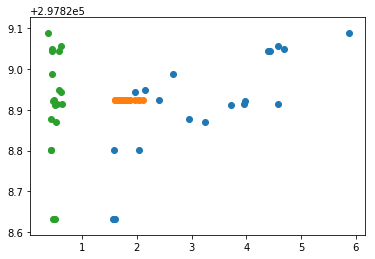

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline
for meth in methods.keys():
    plt.scatter(methods[meth]["times"], methods[meth]["scores"])